# Functions in project 2

In [1]:
import keyboard
import time
import wave
import pyaudio
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    # first divide signal into 10ms segments
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments

# Preemphasize each segement
def Preemphasizing(segment):
    pre=np.zeros(len(segment))
    pre[0]=segment[0]
    for i in range(1,len(segment)):
        pre[i]=segment[i]-0.95*segment[i-1]
    return pre

# Window each preemphasized segement
def windowing(pre):
    pre=pre*np.hamming(len(pre))
    return pre

# Zero pad each windowed segement
def zero_padding(windowed):
    #zero padding for FFT
    length=512
    windowed_len=len(windowed)
    padding_len=length-windowed_len
    zeros=np.zeros((padding_len,))
    zero_padded=np.concatenate((windowed,zeros))
    return zero_padded

# Calculate the power spectrum of a segement
def FFT(frame):
    length=512
    fft=np.fft.rfft(frame, length)
    magnitude = np.abs(fft)
    power = ((1.0 / length) * ((magnitude) ** 2)) 

    return power

# Mel warping function
def warping_function(Hz):
    Mel = 2595 * np.log10(1+Hz/700)
    return Mel
# inverse function
def inverse_warping(Mel):
    Hz = 700*(np.power(10,Mel/2595)-1) 
    return Hz

# calculate mel spectra and log mel spectra
def filterbanks(power,filter_num,minHz=133.33,maxHz=6855.4976,length=512):
    maxMel=warping_function(maxHz)
    minMel=warping_function(minHz)
    #get start and end points of triangle filters in Mel
    pointsInMel=np.linspace(minMel,maxMel,filter_num+2)
    #get start and end points of triangle filters in Hz
    pointsInHz=inverse_warping(pointsInMel)
    #get start and end points of tiangle filters in total 257 points
    ranges=np.floor(length/2*pointsInHz/(maxHz-minHz))
    #normalize the triangle filters according to the lower bound
    ranges=ranges-ranges[0]
    #create filter banks with size(number of filters=40, points in power spectrum=257)
    filter_banks=np.zeros((filter_num,len(power)))
    for i in range(1,filter_num+1): 
        #get the left half of the traingle
        for j in range(int(ranges[i-1]),int(ranges[i])):
            filter_banks[i-1,j]=(j-ranges[i-1])/(ranges[i]-ranges[i-1])
        #get the right half of the traingle
        for j in range(int(ranges[i]),int(ranges[i+1])):
            filter_banks[i-1,j]=(ranges[i+1]-j)/(ranges[i+1]-ranges[i])
    #mel spectrum
    filter_banks=filter_banks.T
    Mel=np.dot(power,filter_banks)
    Mel=np.where(Mel==0,np.finfo(float).eps,Mel)
    #log mel spectrum
    Log_Mel=10*np.log(Mel) 
    return Mel,Log_Mel

from scipy.fftpack import dct,idct
# use dct to get the cepstral_coefficients
def mel_cepstrum(log_mel):
    cepstral_coefficients=dct(log_mel,axis=-1, type=2, norm='ortho')
    return cepstral_coefficients[:13]

# get idct
def IDCT(log_mel,num):
    IDCT_coefficients=idct(log_mel,type=2, n=num, norm='ortho')
    return IDCT_coefficients

# get log mel spectrum matrix, mel cpestrum matrix and idct matrix, given segments
def get_matrix(segments,num):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    IDCT_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum,num)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
        IDCT_spectrum=IDCT(Mel_cepstrum,num)
        IDCT_matrix.append(IDCT_spectrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix,IDCT_matrix
#plot the spectrum and cepstrum
def plot_show(matrix, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(311)
    plt.imshow(matrix.T, origin='lower')
    plt.title(title)

#load wav file
def load_wav(file_path):
    wav_file = wave.open(file_path, 'r')
    # Get the audio data
    frames = wav_file.readframes(-1)
    signal = np.frombuffer(frames, dtype=np.int16)

    # Get the sample rate and time axis
    sample_rate = wav_file.getframerate()
    duration = len(signal) / sample_rate
    time = np.linspace(0., duration, len(signal))
    
    # Close the WAV file
    wav_file.close()
    return signal, sample_rate

# Problem 1

## 1. Mean subtraction and variance normalization

In [2]:
def mean_subtraction(matrix):
    means = np.mean(matrix, axis=0)/(np.shape(matrix)[0])
    matrix=matrix-means
    return matrix

def var_normalization(matrix):
    sd=np.sqrt(np.sum(np.square(matrix),axis=0)/(np.shape(matrix)[0]))
    return matrix*(1/sd)

## Get cepstrum feature

In [3]:
def get_cepstrum_features(file):
    signal, sample_rate=load_wav(file)
    seg=create_segments(signal,sample_rate)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=get_matrix(seg,40)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix),np.array(IDCT_matrix)

    mean_subtracted=mean_subtraction(mel_cepstrum_matrix)
    var_normalized=var_normalization(mean_subtracted)
    return var_normalized

## Get MFCC using python_speech_features package

In [4]:
import scipy.io.wavfile as wav
from python_speech_features import mfcc
def get_MFCC(wavename):#with normalization
    import numpy as np
    import scipy.io.wavfile as wav
    from python_speech_features import mfcc
    fs, audio = wav.read(wavename)
    feature_mfcc = mfcc(audio, samplerate=fs,
                        winlen=0.020,
               winstep=0.01,
               numcep=13,
               nfilt=40,
               nfft=512,
               lowfreq=133.33,
               highfreq=6855.4976,
               preemph=0.95,
               ceplifter=0,
               appendEnergy=False,
               winfunc=np.hamming)
    mfcc=[]
    mfcc.append(np.hstack([feature_mfcc[0],feature_mfcc[0],feature_mfcc[0]]))
    for i in range(1,len(feature_mfcc)-1):
        delta=np.zeros(13)
        for j in range(13):
            delta[j]=feature_mfcc[i+1][j]-feature_mfcc[i-1][j]
        mfcc.append(np.hstack([feature_mfcc[i],delta]))
    mfcc.append(np.hstack([feature_mfcc[-1],feature_mfcc[-1],feature_mfcc[-1]]))

    for i in range(1,len(mfcc)-1):
        acc=np.zeros(13)
        for j in range(13):
            acc[j]=mfcc[i+1][13+j]-mfcc[i-1][13+j]
        mfcc[i]=np.hstack([mfcc[i],acc])
    mfccs=np.array(mfcc)
    std=np.std(mfccs)
    var=np.var(mfccs,1)
    for i in range(len(mfccs)):
        for j in range(39):
            mfccs[i][j]=mfccs[i][j]/var[i]
    return mfccs

## 2. DTW

In [5]:
# calculate the Euclidean distance between two feature vectors
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# get DTW distance
def DTW(input, template):       
    new_array=np.full(len(template),np.inf)
    old_array=np.full(len(template),np.inf)
    for i in range(len(input)):
        if i==0:
            old_array[0]=euclidean_distance(input[i],template[0])
        else:
            for j in range(len(template)):
                if j==0:
                    new_array[0]=old_array[0]+euclidean_distance(input[i], template[j])
                elif j==1:
                    cost=min(old_array[j-1],old_array[j])
                    new_array[1]=euclidean_distance(input[i],template[j])+cost
                else:
                    cost=min(old_array[j-1],old_array[j-2],old_array[j])
                    new_array[j]=euclidean_distance(input[i],template[j])+cost
            old_array=new_array
            new_array=np.full(len(template),np.inf)
            
    # Return the DTW distance
    return old_array[len(template)-1]

In [6]:
# get MFCC of 10 templates
template_feature_matrix=[]
for i in range(10):
    template_feature=get_cepstrum_features('recorded_digits/'+str(i)+'_template.wav')
    template_feature_matrix.append(template_feature)
dtw_result=np.zeros((10,5))

# generate the results for training data and put them in the matrix
def DTW_recognition(templates):
    result=np.zeros((len(templates),5))
    for i in range(len(templates)):
        for j in range(1,6):
            training_feature=get_cepstrum_features('recorded_digits/'+str(i)+'_training_'+str(j)+'.wav')
            dtw=DTW(training_feature,templates[0])
            type=0
            for k in range(1,10):
                cur_dtw=DTW(training_feature,template_feature_matrix[k])
                if cur_dtw<dtw:
                    dtw=cur_dtw
                    type=k
            result[i][j-1]=type
    return result

## Simple DTW accuracy

In [7]:
# show the accuracy and runtime of the DTW
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
dtw_result=DTW_recognition(template_feature_matrix)
print(dtw_result)
differing_positions = dtw_result != correct_classifications
print('DTW Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2.]
 [3. 3. 1. 2. 2.]
 [1. 4. 1. 1. 4.]
 [5. 5. 1. 1. 1.]
 [6. 6. 8. 8. 6.]
 [1. 1. 1. 7. 7.]
 [6. 6. 8. 8. 8.]
 [1. 9. 9. 9. 1.]]
DTW Accuracy: 0.6
Runtime: 16.401645 seconds


## 3. Time-synchronous DTW

In [8]:
# do time synchronous DTW
def Time_synchronous_DTW(input,templates):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    # use two arrays with the length of input template to record the distance at each position
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1):
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
        else:
            for k in range(len(template_len)-1):
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    new_array[j]=euclidean_distance(templates[k][j-low],input[i])+cost
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)
            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type
        


In [9]:
# get result matrix of TS_DTW
def TS_DTW_recognition(templates):
    result=np.zeros((len(templates),5))
    for i in range(len(templates)):
        for j in range(1,6):
            training_feature=get_cepstrum_features('recorded_digits/'+str(i)+'_training_'+str(j)+'.wav')
            type=Time_synchronous_DTW(training_feature,templates)
            result[i][j-1]=type
    return result

## Time-synchronous DTW Accuracy

In [10]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
ts_dtw_result=TS_DTW_recognition(template_feature_matrix)
print(ts_dtw_result)
differing_positions = ts_dtw_result != correct_classifications
print('TS_DTW Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2.]
 [3. 3. 1. 2. 2.]
 [1. 4. 1. 1. 4.]
 [5. 5. 1. 1. 1.]
 [6. 6. 8. 8. 6.]
 [1. 1. 1. 7. 7.]
 [6. 6. 8. 8. 8.]
 [1. 9. 9. 9. 1.]]
TS_DTW Accuracy: 0.6
Runtime: 16.185054 seconds


## 4. TS-DTW with pruning

In [11]:
# Time synchronous DTW with pruning
def Pruning(input,templates,threshold):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    ranges=[[] for x in range(10)]
    best=np.full(len(templates),np.inf)
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1): 
                cost=euclidean_distance(templates[k][0],input[i])
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
                best[k]=cost
                ranges[k].append(template_len[k]) 
            # print(ranges,best)
        else:
            for k in range(len(template_len)-1):
                for y in range(len(ranges[k])):
                    # prun out nodes that are greater than 1+threshold times the smallest distance in the old_array
                    if old_array[ranges[k][y]]>best[k]*(1+threshold):
                        old_array[ranges[k][y]]=np.inf
                ranges[k]=[]
                best[k]=np.inf
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                best[k]=min(new_array[low],new_array[low+1])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    if cost==np.inf: 
                        new_array[j]=cost
                    else: 
                        dist=euclidean_distance(templates[k][j-low],input[i])+cost
                        new_array[j]=dist
                        if dist<best[k]:
                            best[k]=dist
                        ranges[k].append(j)
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type

In [12]:
# get result matrix of TS_DTW with pruning
def Pruning_recognition(templates,threshold):
    result=np.zeros((len(templates),5))
    for i in range(len(templates)):
        for j in range(1,6):
            training_feature=get_cepstrum_features('recorded_digits/'+str(i)+'_training_'+str(j)+'.wav')
            type=Pruning(training_feature,templates,threshold)
            result[i][j-1]=type
    return result

## Accuracy of time synchronous DTW with pruning

In [13]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
pruning_result=Pruning_recognition(template_feature_matrix,0.35)
print(pruning_result)
differing_positions = pruning_result != correct_classifications
print('TS_DTW_with_Pruning Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2.]
 [3. 3. 1. 2. 2.]
 [1. 4. 1. 1. 4.]
 [5. 5. 1. 1. 1.]
 [6. 6. 8. 8. 6.]
 [1. 1. 1. 7. 7.]
 [6. 6. 8. 8. 8.]
 [1. 9. 9. 9. 1.]]
TS_DTW_with_Pruning Accuracy: 0.6
Runtime: 13.177780 seconds


## Plot of different accuracy of pruning for different threshold

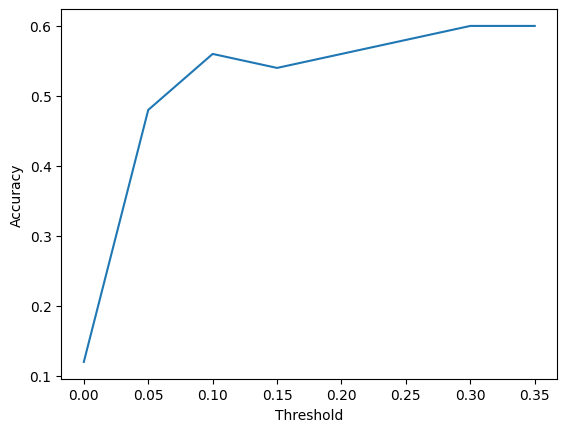

In [14]:
a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
accuracy=[]
for i in range(8):
    pruning_result=Pruning_recognition(template_feature_matrix,0.05*i)
    differing_positions = pruning_result != correct_classifications
    accuracy.append(1-np.sum(differing_positions)/50)
x = np.linspace(0.0,0.05*7,num=8)

plt.plot(x, accuracy)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.show()

The best threshold is 0.3

## 5. Multiple template

## Template Averaging

## Use DTW to align master template and other templates

In [15]:
def DTW_template_averaging(input,template):      
    previous_matrix=[[(-1,-1) for j in range(len(template))]for i in range(len(input))]
    new_array=np.full(len(template),np.inf)
    old_array=np.full(len(template),np.inf)
    for i in range(len(input)):
        if i==0:
            old_array[0]=euclidean_distance(input[i],template[0])
        else:
            for j in range(len(template)):
                if j==0:
                    new_array[0]=old_array[0]+euclidean_distance(input[i], template[j])
                    previous_matrix[i][j]=(i-1,0)
                elif j==1:
                    cost=min(old_array[j-1],old_array[j])
                    if cost!=np.inf:
                        if cost==old_array[j-1]: previous_matrix[i][j]=(i-1,j-1)
                        else: previous_matrix[i][j]=(i-1,j)
                    new_array[1]=euclidean_distance(input[i],template[j])+cost
                else:
                    cost=min(old_array[j-1],old_array[j-2],old_array[j])
                    if cost!=np.inf:
                        if cost==old_array[j-1]: previous_matrix[i][j]=(i-1,j-1)
                        elif cost==old_array[j-2]: previous_matrix[i][j]=(i-1,j-2)
                        else: previous_matrix[i][j]=(i-1,j)
                    new_array[j]=euclidean_distance(input[i],template[j])+cost
            old_array=new_array
            new_array=np.full(len(template),np.inf)
    path=[]
    transition_type=[]
    previous_point=previous_matrix[len(input)-1][len(template)-1]
    
    i=len(input)
    if previous_point[1]==len(template)-1:
        transition_type.append(0)
    elif previous_point[1]==len(template)-2:
        transition_type.append(1)
    else:
        transition_type.append(2) 
    while i>1 :
        path.append(previous_point)
        current=previous_point
        previous_point=previous_matrix[previous_point[0]][previous_point[1]]
        if current[1]==previous_point[1]:
           transition_type.append(0)
        elif current[1]==previous_point[1]+1:
            transition_type.append(1)
        else:
            transition_type.append(2)
        i-=1
    # print(path)
    return np.flip(transition_type[:-1])

In [16]:
def get_transition_type(index,num):
    template=get_cepstrum_features('recorded_digits/'+str(index)+'_template.wav')
    type=[]
    alignment=template
    count=np.full(len(alignment),1)
    for i in range(6,num+6):
        input=get_cepstrum_features('recorded_digits/'+str(index)+'_training_'+str(i)+'.wav')
        curr_type=DTW_template_averaging(input,template)
        type.append(curr_type)
        # align the template and input by the trasition types
        k=0
        j=0
        m=0
        alignment[0]+=input[0]
        count[0]+=1
        while m<len(curr_type):
            if curr_type[m]==1:
                k+=1
                j+=1
            elif curr_type[m]==2:
                j+=1
                k+=2
            else:
                j+=1
            alignment[k]+=input[j]
            count[k]+=1
            m+=1       
    return alignment,count

In [17]:
averaged_template=[]
for i in range(10):
    alignment,count=get_transition_type(i,4)
    count = count[:, np.newaxis]
    averaged_template.append(alignment/count)
 

## Test by DTW

In [18]:
# show the accuracy and runtime of the DTW
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
dtw_result=DTW_recognition(averaged_template)
print(dtw_result)
differing_positions = dtw_result != correct_classifications
print('DTW Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 0. 0. 2.]
 [3. 3. 0. 0. 0.]
 [1. 4. 1. 1. 4.]
 [5. 5. 1. 0. 0.]
 [6. 6. 8. 8. 6.]
 [1. 1. 0. 7. 7.]
 [6. 6. 8. 8. 8.]
 [1. 9. 9. 9. 0.]]
DTW Accuracy: 0.5800000000000001
Runtime: 15.998451 seconds


## Test by Time Synchronous DTW

In [19]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
ts_dtw_result=TS_DTW_recognition(averaged_template)
print(ts_dtw_result)
differing_positions = ts_dtw_result != correct_classifications
print('TS_DTW Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 8. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2.]
 [3. 3. 3. 3. 2.]
 [1. 4. 4. 4. 4.]
 [5. 5. 9. 9. 5.]
 [6. 6. 6. 6. 6.]
 [7. 7. 1. 7. 7.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]]
TS_DTW Accuracy: 0.84
Runtime: 16.082673 seconds


## Test by pruning

In [20]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a,a,a,a))
pruning_result=Pruning_recognition(averaged_template,0.3)
print(pruning_result)
differing_positions = pruning_result != correct_classifications
print('TS_DTW_with_Pruning Accuracy:',1-np.sum(differing_positions)/50)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0. 1. 8. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2.]
 [3. 3. 6. 3. 2.]
 [1. 4. 4. 4. 4.]
 [5. 5. 9. 9. 5.]
 [6. 6. 6. 6. 6.]
 [7. 7. 1. 7. 7.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]]
TS_DTW_with_Pruning Accuracy: 0.8200000000000001
Runtime: 12.693529 seconds


# Problem 2

## Training an HMM

In [21]:
# negative log Gaussian
def log_Gaussian(m, sigma_square, x):
    left=0.5*np.sum(np.log(2*np.pi*sigma_square))
    right=0.5*np.sum(np.square((x-m))/sigma_square)
    return left+right

In [22]:
def get_states(P):
    current_state,current_frame=np.array(P.shape)-1
    current_state_array=[current_state]
    while True:
      if current_state<=0 or current_frame<=1:
        break
      current_frame-=1
      if current_state>2:
          to_check=[P[current_state][current_frame-1],P[current_state-1][current_frame-1],P[current_state-2][current_frame-1]]
          track=np.argmin(to_check)
      elif current_state>1:
          to_check=[P[current_state][current_frame-1],P[current_state-1][current_frame-1]]
          track=np.argmin(to_check)
      else:
          track=0
      if track==0:
          current_state_array.insert(0,current_state)
      elif track==1:
          current_state-=1
          current_state_array.insert(0,current_state)
      else:
          current_state-=2
          current_state_array.insert(0,current_state)
    return current_state_array

In [23]:
def HMM_DTW(mean,data,state,T,covariance):
    mean=np.vstack([np.zeros(len(data[0])),mean])
    covariance=np.vstack([np.full(len(data[0]),1),covariance])
    data=np.vstack([np.zeros(len(data[0])),data])
    state+=1
    previous=[[(-1,-1) for i in range(len(data))] for j in range(state)]
    P=np.zeros((state,len(data)))
    for j in range(len(data)):
        for i in range(state):
            node_cost=log_Gaussian(mean[i],covariance[i],data[j])
            if i>=2:
                minimum=min(P[i][j-1]+T[i][i],P[i-1][j-1]+T[i-1][i],P[i-2][j-1]+T[i-2][i])
                P[i][j]=minimum+node_cost
            elif i>=1:
                minimum=min(P[i][j-1]+T[i][i],P[i-1][j-1]+T[i-1][i])
                P[i][j]=min(P[i][j-1]+T[i][i],P[i-1][j-1]+T[i-1][i])+node_cost
            else:
                P[i][j]=P[i][j-1]+node_cost
    P=P/len(data)
    dist=P[-1][-1]
    states=get_states(P)
    return dist,states  

In [24]:
def initialize_boundary(data,state=5):
    states=[]
    for i in range(len(data)):
        length=len(data[i])//5
        remainder=len(data[i])%5
        curr_state=np.zeros(len(data[i])).astype(int)   
        for i in range(1,state+1):
            curr_state[length*(i-1):length*i]=int(i)
        if remainder!=0:
            curr_state[-remainder:]=int(state)
        states.append(curr_state)       
    return states
    # calculate state means and covarriances 
def MeanAndVar(data,states,state=5):
    means=[]
    covs=[]
    nodes=[[] for i in range(state+1)]#record nodes in different states
    for i in range(len(data)):
        for j in range(len(states[i])):
            nodes[states[i][j]].append(data[i][j])
    for i in range(1,state+1):
        mean=np.mean(nodes[i],0)
        means.append(mean)
        node=np.array(nodes[i])
        cov=np.cov(np.array(node).T)
        cov=np.diagonal(cov, offset=0, axis1=0, axis2=1)
        covs.append(cov)
    return means,covs
        
def TransitionScore(states,state=5):
    score=np.full((state+1,state+1),np.inf)
    num_nodes_in_state=np.zeros(state+1)
    for i in range(len(states)):
        for j in range(len(states[i])):
            num_nodes_in_state[states[i][j]]+=1
    for i in range(1,state+1):
        for j in range(state+1):
            if i==j: score[i][j]=-np.log((num_nodes_in_state[i]-state)/num_nodes_in_state[i])
            elif i==j-1: score[i][j]=-np.log(state/num_nodes_in_state[i])
    score[0][1]=0
    score[state][state]=0
    return score

In [25]:
def Training_HMM(data,state=5):
    # initialize boundary matrix
    states=initialize_boundary(data)
    # mean and covariance for the initial state segment
    mean,cov=MeanAndVar(data,states)
    
    # calculate transition score
    score=TransitionScore(states)
    best_distance=-np.inf
    for i in range(1,100):
        curr_dist=0
        for j in range(len(data)):
            distance,states[j]=HMM_DTW(mean,data[j],5,score,cov)
            curr_dist+=distance
        # mean and covariance for the initial state segment
        mean,cov=MeanAndVar(data,states)
        # calculate transition score
        score=TransitionScore(states)
        # do DTW to get new state segment
        improvement=best_distance-curr_dist
        best_distance=curr_dist
        # print(improvement)
        if abs(improvement)<0.0015:
            # print("Number of iterations:",i)
            break
    return mean, cov, score

In [26]:
means=[]
covariances=[]
scores=[]
for j in range(10):
    data=[]
    data.append(get_cepstrum_features('recorded_digits/'+str(j)+'_template.wav'))
    for i in range(1,5):
        data.append(get_cepstrum_features('recorded_digits/'+str(j)+'_training_'+str(i)+'.wav'))
    mean,cov,score=Training_HMM(data)
    means.append(mean)
    covariances.append(cov)
    scores.append(score)

In [27]:
count=0
for i in range(10):
    for j in range(5,10):
        best_dist=np.inf
        test_data=get_cepstrum_features('recorded_digits/'+str(i)+'_training_'+str(j)+'.wav')
        type=-1
        for k in range(10):
            dist,state=HMM_DTW(means[k],test_data,5,scores[k],covariances[k])
            if min(dist,best_dist)==dist:
                best_dist=dist
                type=k
        if type!=i: count+=1
print('Accuracy:',1-count/50)

Accuracy: 0.78


# Problem 3

## HMM with Gaussian Mixture Model

In [28]:
import numpy as np
class Gaussian_total:
    def __init__(self,Gaussian_mean =[],Gaussian_var =[],Gaussian_weight =[],number_of_Gaussian = 0):
        self.Gaussian_mean =[]
        self.Gaussian_var =[]
        self.Gaussian_weight =[]
        self.number_of_Gaussian = number_of_Gaussian
class HMM_total:
    def __init__(self,initial_matrix=[], transition_cost =[], state_mix =[],state_number = 0 ):
        self.initial_matrix=initial_matrix
        self.transition_cost=transition_cost
        self.state_mix=state_mix
        self.state_number=state_number
def gaussian(data,sigma_square,ftheta):
    sigma_square_producted=np.prod(sigma_square,axis=1)
    p=(1/(np.sqrt((2*np.pi)**2 *sigma_square)))*(np.exp(-0.5*np.sum((data-ftheta)**2/sigma_square_producted,axis=1)))
    return p
def log_gaussian(data,sigma_square,ftheta):
    cost= 0.5*np.sum(np.log((2*np.pi)*(sigma_square[0])))+0.5*np.sum(np.square((ftheta-data))/sigma_square)
    return cost
def mix_log_gaussian(mix,input_vector):
    #Author: Huangrui Chu
    #input: mix: mixture of Guassian structure
    #Output: cost 
    cost = 0.0
    for i in range(mix.number_of_Gaussian):
        mu = mix.Gaussian_mean[i][:]
        squared_sigma = mix.Gaussian_var[i][:]
        w = mix.Gaussian_weight[i]
        current_cost = log_gaussian(mu,squared_sigma,input_vector)
        cost += w * current_cost #* pdf(m,v,x)
        
    return cost
def mix_gaussian(mix_gaussian,ftheta):
    cost=0
    for i in range(0,mix_gaussian.number_of_Gaussian):
        Gaussian_mean=mix_gaussian.Gaussian_mean[i][:]
        sigma_square=mix_gaussian.Gaussian_var[i][:]
        Gaussian_weight=mix_gaussian.Gaussian_weight[i]
        cost0=gaussian(Gaussian_mean,sigma_square,ftheta)
        cost=cost+Gaussian_weight*cost0
    return cost
    
def GMM_HMM_DTW(HMM_total,data):
    mark=False
    transition_cost=HMM_total.transition_cost
    temp_list0=np.zeros([len(data[0])])
    temp_list1=np.zeros([len(data[0])])+1
    mixture_of_all_states=[]
    new_GMM=Gaussian_total()
    new_GMM.Gaussian_mean.append(temp_list0)
    new_GMM.Gaussian_var.append(temp_list1)
    new_GMM.Gaussian_weight=[1]
    new_GMM.number_of_Gaussian = 1
    mixture_of_all_states.append(new_GMM)
    for mix in HMM_total.state_mix:
        mixture_of_all_states.append(mix)
    data=np.vstack([temp_list0,data])
    len_mix_of_all_states=len(mixture_of_all_states)
    len_data=len(data)
    P=np.zeros([len_mix_of_all_states,len_data])
    # Finding minimum-cost path
    for j in range(0,len_data):
      for i in range(len_mix_of_all_states):
            C_ij= mix_log_gaussian(mixture_of_all_states[i],data[j])
            if i-2>=0:
                P[i][j]=min(P[i][j-1]+transition_cost[i][i],P[i-1][j-1]+transition_cost[i-1][i],
                            P[i-2][j-1]+transition_cost[i-2][i])+C_ij
            elif i-1>=0:
                P[i][j]=min(P[i][j-1]+transition_cost[i][i],P[i-1][j-1]+transition_cost[i-1][i])+C_ij
            else:
                P[i][j]=P[i][j]+C_ij
    P=P/len_data
    distance=P[-1][-1]
    if mark:
        return distance,get_states(P)
    else:
        return distance

In [29]:
def TransitionScore(states,state=5):
    score=np.full((state+1,state+1),np.inf)
    num_nodes_in_state=np.zeros(state+1)
    for i in range(len(states)):
        for j in range(len(states[i])):
            num_nodes_in_state[states[i][j]]+=1
    for i in range(1,state+1):
        for j in range(state+1):
            if i==j: score[i][j]=-np.log((num_nodes_in_state[i]-state)/num_nodes_in_state[i])
            elif i==j-1: score[i][j]=-np.log(state/num_nodes_in_state[i])
    score[0][1]=0
    score[state][state]=0
    return score

In [30]:
def get_states(P):
    current_state,current_frame=np.array(P.shape)-1
    current_state_array=[current_state]
    while True:
      if current_state<0 or current_frame<1:
        break
      current_frame-=1
      if current_state>2:
          to_check=[P[current_state][current_frame-1],P[current_state-1][current_frame-1],P[current_state-2][current_frame-1]]
          track=np.argmin(to_check)
      elif current_state>1:
          to_check=[P[current_state][current_frame-1],P[current_state-1][current_frame-1]]
          track=np.argmin(to_check)
      else:
          track=0
      if track==0:
          current_state_array.insert(0,current_state)
      elif track==1:
          current_state-=1
          current_state_array.insert(0,current_state)
      else:
          current_state-=2
          current_state_array.insert(0,current_state)
    return current_state_array

In [31]:
def get_node_in_each_state(data,state_number,node_state):
    state_list=[]
    for state in range(state_number+1):
        state_list.append([])
    for k in range(len(data)):
        for i in range(len(node_state[k])):
            j=int(node_state[k][i])
            state_list[j].append(data[k][i])
    return state_list

In [32]:
def initialize_boundary(data,state=5):
    states=[]
    for i in range(len(data)):
        length=len(data[i])//5
        remainder=len(data[i])%5
        curr_state=np.zeros(len(data[i])).astype(int)   
        for i in range(1,state+1):
            curr_state[length*(i-1):length*i]=int(i)
        if remainder!=0:
            curr_state[-remainder:]=int(state)
        states.append(curr_state)
    node_in_states=get_node_in_each_state(data,state,states)
    return node_in_states,states

# Not finished, we tried our best.
-TAT